# Importing Libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Loading dataset

In [2]:
df = pd.read_csv("data/processed/citibike_weather_2022.csv")
df.head()

/var/folders/zj/m82l3gps79nc61v2flg2kkzr0000gn/T/ipykernel_4698/2632922972.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/processed/citibike_weather_2022.csv")


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,PRCP,TMAX,TMIN
0,0CC1D7F53FA21F9A,electric_bike,2022-11-02 05:54:11.481,2022-11-02 06:08:27.471,Park Ave & E 162 St,8016.07,Jerome Ave & W 193 St,8619.02,40.825701,-73.915644,40.866590,-73.897940,casual,2022-11-02,0.0,21.7,13.9
1,EDAECDAE6BF903DE,classic_bike,2022-11-02 18:20:15.611,2022-11-02 19:00:24.787,Broadway & W 61 St,7014.12,Leonard St & Church St,5359.11,40.770030,-73.981968,40.717571,-74.005549,casual,2022-11-02,0.0,21.7,13.9
2,37C06FED49069B80,electric_bike,2022-11-04 18:39:39.873,2022-11-04 18:44:01.851,W 54 St & 11 Ave,6955.05,11 Ave & W 59 St,7059.01,40.768333,-73.992573,40.771497,-73.990460,member,2022-11-04,0.0,22.2,11.1
3,63751973E9A95FB1,classic_bike,2022-11-09 18:02:29.616,2022-11-09 18:19:28.693,Broadway & W 41 St,6560.01,11 Ave & W 59 St,7059.01,40.755136,-73.986580,40.771497,-73.990460,member,2022-11-09,0.0,12.2,5.0
4,F7410DEDF925FBA8,electric_bike,2022-11-12 10:23:11.805,2022-11-12 10:28:24.794,William St & Pine St,5065.12,Leonard St & Church St,5359.11,40.707317,-74.008854,40.717571,-74.005549,member,2022-11-12,2.3,20.6,16.1


# Plotly bar chart: most popular start stations (NYC)

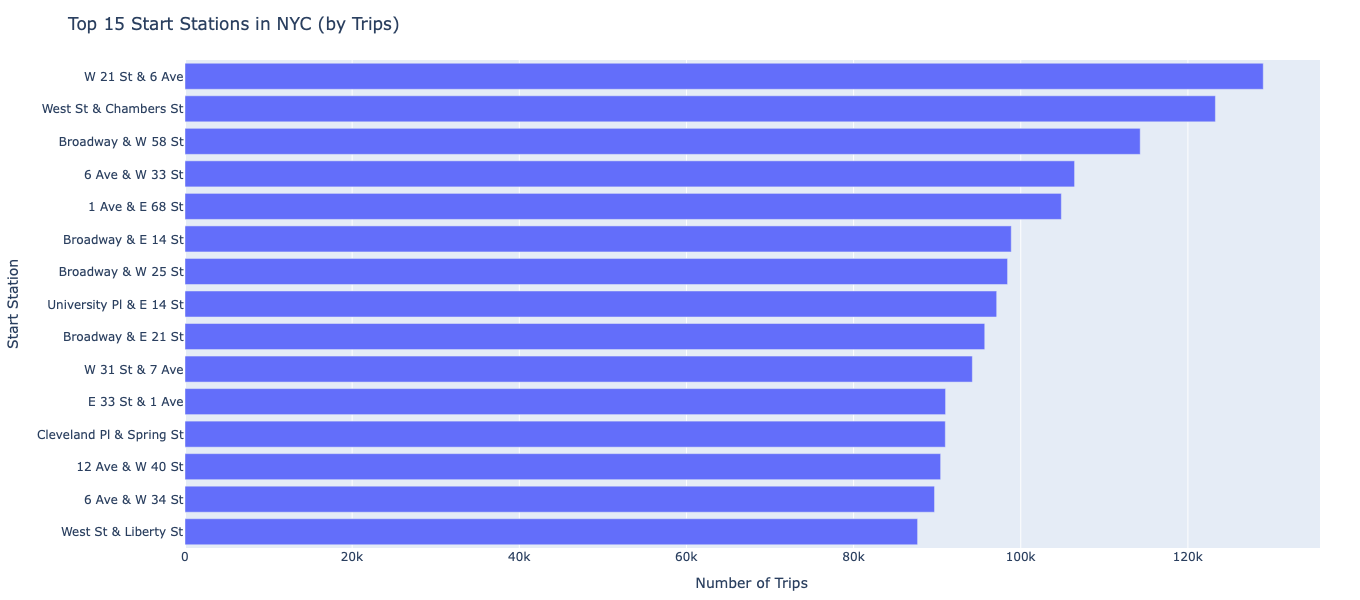

In [3]:
top_stations = (
    df.dropna(subset=["start_station_name"])
      .groupby("start_station_name")
      .size()
      .sort_values(ascending=False)
      .head(15)
      .reset_index(name="trips")
)

fig_bar = px.bar(
    top_stations,
    x="trips",
    y="start_station_name",
    orientation="h",
    title="Top 15 Start Stations in NYC (by Trips)",
    labels={"trips": "Number of Trips", "start_station_name": "Start Station"},
)

fig_bar.update_layout(
    height=600,
    margin=dict(l=40, r=40, t=60, b=40),
    yaxis=dict(categoryorder="total ascending"),
)

fig_bar.show()

# Dual-axis line chart: aggregated trips + temperature 

In [5]:
df["tavg"] = (df["TMAX"] + df["TMIN"]) / 2

In [6]:
# Create a date column + aggregate

df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["date"] = df["started_at"].dt.date

daily = (
    df.dropna(subset=["date"])
      .groupby("date")
      .agg(
          trips=("ride_id", "count"),
          tavg=("tavg", "mean")  # change if your temp column is different
      )
      .reset_index()
)

daily["date"] = pd.to_datetime(daily["date"])
daily.head()

,date,trips,tavg
0,2022-01-01,20428,11.95
1,2022-01-02,43009,9.75
2,2022-01-03,33189,-0.20
3,2022-01-04,36842,-1.90
4,2022-01-05,34230,4.45


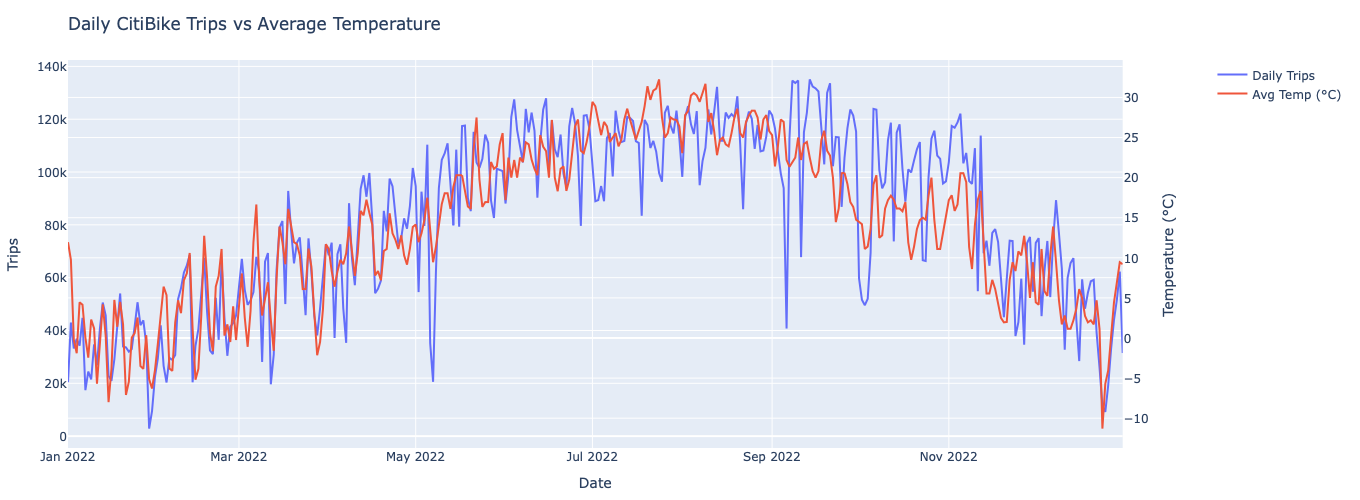

In [8]:
# Make dual-axis chart

fig_dual = make_subplots(specs=[[{"secondary_y": True}]])

fig_dual.add_trace(
    go.Scatter(x=daily["date"], y=daily["trips"], name="Daily Trips", mode="lines"),
    secondary_y=False,
)

fig_dual.add_trace(
    go.Scatter(x=daily["date"], y=daily["tavg"], name="Avg Temp (°C)", mode="lines"),
    secondary_y=True,
)

fig_dual.update_layout(
    title="Daily CitiBike Trips vs Average Temperature",
    xaxis_title="Date",
    height=500,
    margin=dict(l=40, r=40, t=60, b=40),
)

fig_dual.update_yaxes(title_text="Trips", secondary_y=False)
fig_dual.update_yaxes(title_text="Temperature (°C)", secondary_y=True)

fig_dual.show()

# Creating the Streamlit “.py” file

In [ ]:
import streamlit as st
import pandas as pd
import streamlit.components.v1 as components

st.set_page_config(
    page_title="CitiBike + Weather Dashboard",
    layout="wide",
)

st.title("CitiBike + Weather Dashboard (2022)")
st.write(
    "This dashboard explores CitiBike trip patterns in New York City and how ridership relates to weather conditions."
)

@st.cache_data
def load_data():
    return pd.read_csv("data/processed/citibike_weather_2022.csv")

df = load_data()

#  - Chart 1: Top stations -
st.subheader("Most Popular Start Stations")

top_stations = (
    df.dropna(subset=["start_station_name"])
      .groupby("start_station_name")
      .size()
      .sort_values(ascending=False)
      .head(15)
      .reset_index(name="trips")
)

fig_bar = px.bar(
    top_stations,
    x="trips",
    y="start_station_name",
    orientation="h",
    title="Top 15 Start Stations (by Trips)",
    labels={"trips": "Number of Trips", "start_station_name": "Start Station"},
)
fig_bar.update_layout(height=600, yaxis=dict(categoryorder="total ascending"))
st.plotly_chart(fig_bar, use_container_width=True)

# - Chart 2: Trips vs temperature (dual axis) -
st.subheader("Trips vs Temperature Over Time")

df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["date"] = df["started_at"].dt.date

daily = (
    df.dropna(subset=["date"])
      .groupby("date")
      .agg(
          trips=("ride_id", "count"),
          tavg=("tavg", "mean")
      )
      .reset_index()
)

daily["date"] = pd.to_datetime(daily["date"])

fig_dual = make_subplots(specs=[[{"secondary_y": True}]])
fig_dual.add_trace(
    go.Scatter(x=daily["date"], y=daily["trips"], name="Daily Trips", mode="lines"),
    secondary_y=False,
)
fig_dual.add_trace(
    go.Scatter(x=daily["date"], y=daily["tavg"], name="Avg Temp", mode="lines"),
    secondary_y=True,
)

fig_dual.update_layout(title="Daily Trips vs Average Temperature", height=500)
fig_dual.update_yaxes(title_text="Trips", secondary_y=False)
fig_dual.update_yaxes(title_text="Temperature", secondary_y=True)

st.plotly_chart(fig_dual, use_container_width=True)

# - Kepler map (HTML) -
st.subheader("Trip Map (kepler.gl)")

with open("outputs/task_2_5_kepler_map.html", "r", encoding="utf-8") as f:
    html_data = f.read()

components.html(html_data, height=700, scrolling=True)

2026-02-12 15:13:41.984 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 15:13:41.988 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 15:13:42.106 
  command:

    streamlit run /opt/anaconda3/envs/citibike/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2026-02-12 15:13:42.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 15:13:42.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 15:13:42.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 15:13:42.109 Thread 'MainThread': missing ScriptRunContext! This warning can be ig

# Random sample of the main “df”

In [3]:
import pandas as pd
import os

# creating a smaller version of my dataframe
sample_df = df.sample(frac=0.10, random_state=32)

# save it as a real file
sample_df.to_csv("citibike_sample_seed32.csv", index=False)

# check the file size
print("File size (MB):", round(os.path.getsize("citibike_sample_seed32.csv")/1024/1024,2))

File size (MB): 627.17
